## Plot the throughput of experiment 1 of version 3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import io
import glob

## Function Read CSV files of Throughput from Iperf log


In [2]:
def getDataframeThru(df,start_row,measurement_interval,header_range):
    '''
    This functions will import the data from txt file and return the dataframe without the header of txt file.
    Input: 
        measurement_interval = 30 (sec) : 
        header_range = 10 lines
        start_row = 0 
    Return: 
        df1t : dataframe of througput and jitter
    '''
    
    df1 = df.drop(labels=range(start_row, header_range), axis=0)
    df1t = df1.drop(labels=range(measurement_interval, len(df)), axis=0)
    
    return df1t

In [3]:
def getDatafromTxT(filename, headerrange):
    """
    Get dataframe from txt file:
    filename : xxx.txt
    headerrange : number of lines that needed to be removed. 
    
    return : df : datafame type
    """
    h = headerrange + 1
    skip_1 = list(range(0,h, 1))
    df = pd.read_csv(filename,
        skiprows=skip_1,
        header=None,
        delimiter=' ',
        skipinitialspace=True,
        error_bad_lines=False)
    return df


In [4]:
## Find start row index of itteration
def getStartEndID(df,start_data,end_data):
    """
    to clean dataframe and return the data with new header
    Input: 
        df : datafram without header of txt file 
    Output
        strat_indices_list : start indices list
    """
    # creating and passing series to new column
    df["Start"]= df[2].str.find(start_data)
    df["End"]= df[2].str.find(end_data)

    index = df.index
    strat_indices = index[df["Start"]==0.0]
    strat_indices_list = strat_indices.tolist()
    end_indices = index[df["End"]==0.0]
    end_indices_list = end_indices.tolist()
    
    
    return strat_indices_list, end_indices_list
    

In [5]:
def getCleanData(df,strat_indices_list,end_indices_list):
    """
    
    """
    df_all = df.drop(labels=range(1, len(df)), axis=0) # create new df
    start_row = 0
    c = 0
    for i in strat_indices_list: 
        
        h = i
        print('h =',h)
        m = end_indices_list[c]
        print('m =', m)
        df1 = getDataframeThru(df,start_row,m,h)
        print('df1 = ', df1)
        result = pd.concat([df_all,df1])
        df_all = result
        c = c + 1
        if i == 0:
            
            df_all = df_all.drop(labels=0, axis=0)
        
        
    return df_all

In [6]:
def superClean(filename,headerrange,start_data,end_data):
    """
    Clean Data from CSV file with remove the unnecessary header
    """
    df = getDatafromTxT(filename, headerrange)
    strat_indices_list, end_indices_list = getStartEndID(df,start_data,end_data)
    df_all = getCleanData(df,strat_indices_list,end_indices_list)
    df_all_new = df_all.drop(df_all.columns[[0,1,3,5,7,9]], axis=1)  # Replace new columns header
    df_all_new.rename({2 :'Interval', 4 : 'Transfer', 6 :'Bitrate', 8 :'Jitter', 10 :'Lost/Total Datagrams'}, axis=1, inplace=True)
    df = df_all_new.drop(range(0,1))
    df_all_new['Bitrate'] = df['Bitrate'].astype(float) 
    time = np.array(range(len(df_all_new.index)))

    df_all_new['Time'] = time
    df_all_new['Time'] = df_all_new['Time'].astype(int) 
    # avergae throughput 
    sumThroughput = df_all_new['Bitrate'].sum()
    avgSumThroughput = sumThroughput/len(time)
    print('avg  :', avgSumThroughput)
    var_throughput = df_all_new['Bitrate'].var()
    print('var  :', var_throughput)
    
    return avgSumThroughput, var_throughput

    
    

In [7]:
def readCSV2pd_Thru(directoryPath,tf_load,edge_name,start_data,end_data,headerrange):
    """
    This function is to read a CSV file and return the average value and varience
    input: directoryPath : path of file names
            tf_load : list of traffic load
    """
    avg_Thr = []
    var_Thr = []
    for tf in tf_load:
        cpu_data = pd.DataFrame()
        for file_name in glob.glob(directoryPath+edge_name+str(tf)+'.csv'):
            avg_thr,var_thr = superClean(file_name,headerrange,start_data,end_data)
            
            avg_Thr.append(avg_thr)
            var_Thr.append(var_thr)
    return avg_Thr, var_Thr

## Read File CSV

In [8]:
headerrange = 7
start_data = '9.0-10.0'
end_data = '60.0-61.0'
tf_load  = [i*2 for i in range(2,20)]
edge_name = 'edge1_M'
directoryPath = '/Users/kalika/PycharmProjects/Privacy_SDN_Edge_IoT/PlanB/CPU_utilization_Experiment/version3_Experiment_style/Experiment1/Edge1_iperf_log/'
avg_thr, var_thr = readCSV2pd_Thru(directoryPath,tf_load,edge_name,start_data,end_data,headerrange)

b'Skipping line 85: expected 9 fields, saw 12\n'
b'Skipping line 86: expected 9 fields, saw 12\n'
b'Skipping line 85: expected 9 fields, saw 12\n'
b'Skipping line 85: expected 9 fields, saw 12\n'
b'Skipping line 86: expected 9 fields, saw 12\n'
b'Skipping line 85: expected 9 fields, saw 12\n'
b'Skipping line 85: expected 9 fields, saw 12\n'
b'Skipping line 85: expected 9 fields, saw 12\n'
b'Skipping line 85: expected 9 fields, saw 12\n'
b'Skipping line 85: expected 9 fields, saw 12\n'
b'Skipping line 86: expected 9 fields, saw 12\n'
b'Skipping line 83: expected 9 fields, saw 12\n'


h = 8
m = 59
df1 =      0   1          2    3    4       5     6          7    8  Start  End
8   [  3]   9.0-10.0  sec  512  KBytes  4.20  Mbits/sec  NaN      0   -1
9   [  3]  10.0-11.0  sec  512  KBytes  4.20  Mbits/sec  NaN     -1   -1
10  [  3]  11.0-12.0  sec  511  KBytes  4.19  Mbits/sec  NaN     -1   -1
11  [  3]  12.0-13.0  sec  512  KBytes  4.20  Mbits/sec  NaN     -1   -1
12  [  3]  13.0-14.0  sec  512  KBytes  4.20  Mbits/sec  NaN     -1   -1
13  [  3]  14.0-15.0  sec  511  KBytes  4.19  Mbits/sec  NaN     -1   -1
14  [  3]  15.0-16.0  sec  512  KBytes  4.20  Mbits/sec  NaN     -1   -1
15  [  3]  16.0-17.0  sec  512  KBytes  4.20  Mbits/sec  NaN     -1   -1
16  [  3]  17.0-18.0  sec  511  KBytes  4.19  Mbits/sec  NaN     -1   -1
17  [  3]  18.0-19.0  sec  512  KBytes  4.20  Mbits/sec  NaN     -1   -1
18  [  3]  19.0-20.0  sec  512  KBytes  4.20  Mbits/sec  NaN     -1   -1
19  [  3]  20.0-21.0  sec  511  KBytes  4.19  Mbits/sec  NaN     -1   -1
20  [  3]  21.0-22.0  sec  512 

58  [  3]  59.0-60.0  sec  3.16  MBytes  26.5  Mbits/sec  NaN     -1   -1
avg  : 28.58846153846154
var  : 0.6749490196078426
h = 8
m = 59
df1 =      0   1          2    3     4       5     6          7    8  Start  End
8   [  3]   9.0-10.0  sec  3.70  MBytes  31.0  Mbits/sec  NaN      0   -1
9   [  3]  10.0-11.0  sec  3.63  MBytes  30.5  Mbits/sec  NaN     -1   -1
10  [  3]  11.0-12.0  sec  3.63  MBytes  30.5  Mbits/sec  NaN     -1   -1
11  [  3]  12.0-13.0  sec  3.04  MBytes  25.5  Mbits/sec  NaN     -1   -1
12  [  3]  13.0-14.0  sec  3.45  MBytes  28.9  Mbits/sec  NaN     -1   -1
13  [  3]  14.0-15.0  sec  3.45  MBytes  28.9  Mbits/sec  NaN     -1   -1
14  [  3]  15.0-16.0  sec  3.52  MBytes  29.5  Mbits/sec  NaN     -1   -1
15  [  3]  16.0-17.0  sec  3.57  MBytes  29.9  Mbits/sec  NaN     -1   -1
16  [  3]  17.0-18.0  sec  3.45  MBytes  28.9  Mbits/sec  NaN     -1   -1
17  [  3]  18.0-19.0  sec  3.12  MBytes  26.2  Mbits/sec  NaN     -1   -1
18  [  3]  19.0-20.0  sec  3.57  MBytes  

b'Skipping line 85: expected 9 fields, saw 12\n'
b'Skipping line 85: expected 9 fields, saw 12\n'
b'Skipping line 85: expected 9 fields, saw 12\n'
b'Skipping line 85: expected 9 fields, saw 12\n'
b'Skipping line 85: expected 9 fields, saw 12\n'
b'Skipping line 85: expected 9 fields, saw 12\n'


In [9]:
print('avg',avg_thr)
print('var',var_thr)

avg [4.115961538461538, 6.169038461538463, 8.225000000000001, 10.298076923076923, 12.357692307692307, 14.417307692307698, 16.47692307692307, 18.536538461538463, 20.596153846153847, 22.653846153846146, 24.715384615384615, 26.765384615384612, 28.58846153846154, 28.503846153846162, 27.796153846153842, 28.853846153846153, 28.382692307692313, 28.70961538461539]
var [2.266666666666567e-05, 7.241743109928888e-30, 8.784313725489824e-05, 0.0, 1.5770907217178467e-28, 1.158678897588622e-28, 2.059873595713106e-28, 2.059873595713106e-28, 0.0, 0.18499607843137295, 0.0064000000000000124, 1.094901960784315, 0.6749490196078426, 1.6067843137254902, 3.6476705882352936, 1.0636078431372558, 2.6396313725490206, 1.02083137254902]


In [10]:
headerrange = 7
start_data = '9.0-10.0'
end_data = '60.0-61.0'
tf_load  = [i*2 for i in range(2,20)]
edge_name = 'edge2_M'
directoryPath = '/Users/kalika/PycharmProjects/Privacy_SDN_Edge_IoT/PlanB/CPU_utilization_Experiment/version3_Experiment_style/Experiment1/Edge2_iperf_log/'
avg_thr2, var_thr2 = readCSV2pd_Thru(directoryPath,tf_load,edge_name,start_data,end_data,headerrange)

h = 8
m = 59
df1 =      0   1          2    3    4       5     6          7      8   9  10   11  \
8   [  3]   9.0-10.0  sec  511  KBytes  4.19  Mbits/sec  1.932  ms  0/  356   
9   [  3]  10.0-11.0  sec  512  KBytes  4.20  Mbits/sec  1.491  ms  0/  357   
10  [  3]  11.0-12.0  sec  512  KBytes  4.20  Mbits/sec  1.059  ms  0/  357   
11  [  3]  12.0-13.0  sec  512  KBytes  4.20  Mbits/sec  0.576  ms  0/  357   
12  [  3]  13.0-14.0  sec  511  KBytes  4.19  Mbits/sec  0.917  ms  0/  356   
13  [  3]  14.0-15.0  sec  512  KBytes  4.20  Mbits/sec  0.233  ms  0/  357   
14  [  3]  15.0-16.0  sec  512  KBytes  4.20  Mbits/sec  0.672  ms  0/  357   
15  [  3]  16.0-17.0  sec  511  KBytes  4.19  Mbits/sec  0.451  ms  0/  356   
16  [  3]  17.0-18.0  sec  512  KBytes  4.20  Mbits/sec  0.247  ms  0/  357   
17  [  3]  18.0-19.0  sec  512  KBytes  4.20  Mbits/sec  0.470  ms  0/  357   
18  [  3]  19.0-20.0  sec  511  KBytes  4.19  Mbits/sec  0.432  ms  0/  356   
19  [  3]  20.0-21.0  sec  512  

58  (0%)  NaN     -1   -1  
avg  : 8.225961538461538
var  : 0.000676313725490197
h = 8
m = 59
df1 =      0   1          2    3     4       5     6          7      8   9  10   11  \
8   [  3]   9.0-10.0  sec  1.25  MBytes  10.5  Mbits/sec  0.779  ms  0/  891   
9   [  3]  10.0-11.0  sec  1.25  MBytes  10.5  Mbits/sec  0.785  ms  0/  892   
10  [  3]  11.0-12.0  sec  1.25  MBytes  10.5  Mbits/sec  1.858  ms  0/  892   
11  [  3]  12.0-13.0  sec  1.25  MBytes  10.5  Mbits/sec  0.620  ms  0/  891   
12  [  3]  13.0-14.0  sec  1.25  MBytes  10.5  Mbits/sec  0.822  ms  0/  892   
13  [  3]  14.0-15.0  sec  1.25  MBytes  10.5  Mbits/sec  0.587  ms  0/  891   
14  [  3]  15.0-16.0  sec  1.25  MBytes  10.5  Mbits/sec  0.927  ms  0/  892   
15  [  3]  16.0-17.0  sec  1.25  MBytes  10.5  Mbits/sec  0.868  ms  0/  892   
16  [  3]  17.0-18.0  sec  1.25  MBytes  10.5  Mbits/sec  0.838  ms  0/  891   
17  [  3]  18.0-19.0  sec  1.25  MBytes  10.5  Mbits/sec  0.600  ms  0/  892   
18  [  3]  19.0-20.

h = 8
m = 59
df1 =      0   1          2    3     4       5     6          7      8   9  10    11  \
8   [  3]   9.0-10.0  sec  2.25  MBytes  18.9  Mbits/sec  0.800  ms  0/  1606   
9   [  3]  10.0-11.0  sec  2.25  MBytes  18.9  Mbits/sec  1.084  ms  0/  1605   
10  [  3]  11.0-12.0  sec  2.25  MBytes  18.9  Mbits/sec  0.671  ms  0/  1603   
11  [  3]  12.0-13.0  sec  2.25  MBytes  18.9  Mbits/sec  0.623  ms  0/  1606   
12  [  3]  13.0-14.0  sec  2.25  MBytes  18.9  Mbits/sec  0.683  ms  0/  1604   
13  [  3]  14.0-15.0  sec  2.25  MBytes  18.9  Mbits/sec  0.657  ms  0/  1606   
14  [  3]  15.0-16.0  sec  2.25  MBytes  18.9  Mbits/sec  0.690  ms  0/  1605   
15  [  3]  16.0-17.0  sec  2.25  MBytes  18.9  Mbits/sec  0.802  ms  0/  1603   
16  [  3]  17.0-18.0  sec  2.25  MBytes  18.9  Mbits/sec  0.698  ms  0/  1606   
17  [  3]  18.0-19.0  sec  2.25  MBytes  18.9  Mbits/sec  0.796  ms  0/  1603   
18  [  3]  19.0-20.0  sec  2.25  MBytes  18.9  Mbits/sec  0.763  ms  0/  1607   
19  [  3

58  (0%)  NaN     -1   -1  
avg  : 24.68846153846154
var  : 0.29523137254901954
h = 8
m = 59
df1 =      0   1          2    3     4       5     6          7      8   9  10    11  \
8   [  3]   9.0-10.0  sec  3.09  MBytes  25.9  Mbits/sec  0.915  ms  0/  2204   
9   [  3]  10.0-11.0  sec  2.88  MBytes  24.2  Mbits/sec  0.603  ms  0/  2057   
10  [  3]  11.0-12.0  sec  3.52  MBytes  29.6  Mbits/sec  0.498  ms  0/  2513   
11  [  3]  12.0-13.0  sec  3.50  MBytes  29.4  Mbits/sec  0.579  ms  0/  2500   
12  [  3]  13.0-14.0  sec  3.20  MBytes  26.8  Mbits/sec  1.611  ms  0/  2281   
13  [  3]  14.0-15.0  sec  3.28  MBytes  27.5  Mbits/sec  0.646  ms  0/  2338   
14  [  3]  15.0-16.0  sec  3.27  MBytes  27.5  Mbits/sec  0.626  ms  0/  2335   
15  [  3]  16.0-17.0  sec  3.25  MBytes  27.3  Mbits/sec  0.572  ms  0/  2318   
16  [  3]  17.0-18.0  sec  3.25  MBytes  27.3  Mbits/sec  0.628  ms  0/  2320   
17  [  3]  18.0-19.0  sec  3.25  MBytes  27.3  Mbits/sec  0.560  ms  0/  2318   
18  [  3]

58  (0%)  NaN     -1   -1  
avg  : 28.375000000000004
var  : 2.5673960784313734
h = 8
m = 59
df1 =      0   1          2    3     4       5     6          7      8   9  10    11  \
8   [  3]   9.0-10.0  sec  3.39  MBytes  28.5  Mbits/sec  0.925  ms  0/  2421   
9   [  3]  10.0-11.0  sec  3.49  MBytes  29.2  Mbits/sec  0.545  ms  0/  2487   
10  [  3]  11.0-12.0  sec  3.47  MBytes  29.1  Mbits/sec  1.052  ms  0/  2477   
11  [  3]  12.0-13.0  sec  3.59  MBytes  30.1  Mbits/sec  0.518  ms  0/  2561   
12  [  3]  13.0-14.0  sec  3.53  MBytes  29.6  Mbits/sec  0.996  ms  0/  2518   
13  [  3]  14.0-15.0  sec  3.57  MBytes  29.9  Mbits/sec  0.840  ms  0/  2543   
14  [  3]  15.0-16.0  sec  3.48  MBytes  29.2  Mbits/sec  1.307  ms  0/  2485   
15  [  3]  16.0-17.0  sec  3.53  MBytes  29.6  Mbits/sec  0.715  ms  0/  2516   
16  [  3]  17.0-18.0  sec  3.50  MBytes  29.3  Mbits/sec  0.744  ms  0/  2494   
17  [  3]  18.0-19.0  sec  3.50  MBytes  29.4  Mbits/sec  0.838  ms  0/  2497   
18  [  3]

In [11]:
print('avg',avg_thr2)
print('var',var_thr2)

avg [4.115769230769231, 6.169038461538463, 8.225961538461538, 10.294230769230769, 12.35576923076923, 14.419230769230772, 16.474999999999998, 18.53076923076923, 20.582692307692312, 22.63461538461538, 24.68846153846154, 26.744230769230775, 28.550000000000004, 28.500000000000004, 27.778846153846153, 28.84038461538462, 28.375000000000004, 28.680769230769222]
var [4.729411764705776e-05, 5.199999999999885e-05, 0.000676313725490197, 0.001984313725490182, 0.00019607843137254766, 0.0009960784313725558, 0.00019607843137255435, 0.0009647058823529143, 0.002007843137254957, 0.5161254901960786, 0.29523137254901954, 2.2269960784313723, 0.7025019607843137, 1.5084705882352945, 3.477035294117647, 0.9821647058823518, 2.5673960784313734, 0.9965019607843137]


## Plot Throughput

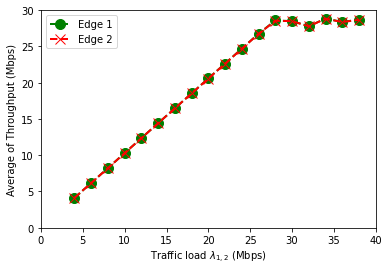

In [13]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)


ax.plot(tf_load, avg_thr, color='green', linestyle='dashed', linewidth = 2,
         marker='o', markerfacecolor='green', markersize=10,label="Edge 1")
ax.plot(tf_load, avg_thr2, color='red', linestyle='dashed', linewidth = 2,
         marker='x', markerfacecolor='red', markersize=10,label="Edge 2")
plt.ylim(0,30)
plt.xlim(0,40)
plt.xlabel('Traffic load $\lambda_{1,2}$ (Mbps)')
# naming the y axis
plt.ylabel('Average of Throughput (Mbps)')

plt.legend()

plt.show()

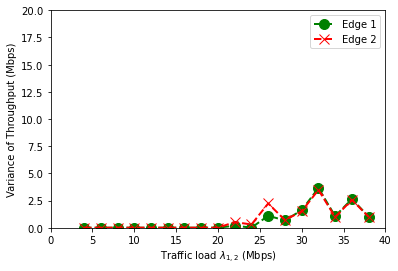

In [14]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)

ax.plot(tf_load, var_thr, color='green', linestyle='dashed', linewidth = 2,
         marker='o', markerfacecolor='green', markersize=10,label="Edge 1")

ax.plot(tf_load, var_thr2, color='red', linestyle='dashed', linewidth = 2,
         marker='x', markerfacecolor='red', markersize=10,label="Edge 2")

plt.ylim(0,20)
plt.xlim(0,40)
plt.xlabel('Traffic load $\lambda_{1,2}$ (Mbps)')
# naming the y axis
plt.ylabel('Variance of Throughput (Mbps)')

plt.legend()

plt.show()
 